In [102]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, TensorDataset
from PIL import Image
from google.colab import drive
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [103]:
# import pandas as pd

# input = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Train_labels.csv')
# array = input['class'].to_numpy()
# print(array)
# #array = array[:-2]
# print(array)

# print(array)

In [104]:
data = pickle.load( open( '/content/gdrive/MyDrive/Colab Notebooks/Train.pkl', 'rb' ))
targets = np.genfromtxt('/content/gdrive/MyDrive/Colab Notebooks/Train_labels.csv', delimiter=',')
# plt.imshow(data[1][0], cmap='gray', interpolation="bicubic")
# plt.show()
# with open('/content/gdrive/MyDrive/Colab Notebooks/Train_labels.csv') as csv_file:
#   #for row in csv_reader:
#    # if row = [nan,nan]
#   #this should remove the correct rows
#   targets = np.delete(targets, (0,-1,-2), axis=0)

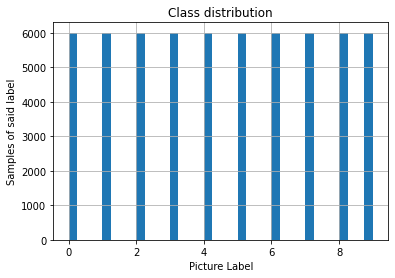

In [105]:
plt.hist(targets[:,1],bins='auto')
plt.title("Class distribution")
plt.ylabel("Samples of said label")
plt.xlabel("Picture Label")
plt.grid()
plt.show()

In [106]:
# data = np.squeeze(data,axis=1)
# data = np.where(data>=0.882,1,0)
# data = torch.from_numpy(data)
# targets = torch.from_numpy(targets)
# print(data.size())
# print(targets.size())
# dataset = TensorDataset(data,targets)

In [107]:
# img_transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize([0.5], [0.5])
# ])

In [108]:
image_transform = transforms.Compose([
                      transforms.ToTensor(),
                      transforms.Normalize((0.1307,), (0.3081,))
                  ])

In [127]:
class MyDataset(Dataset):
    def __init__(self, img_file, label_file, transform=None, idx = None):
        self.data = pickle.load( open( img_file, 'rb' ), encoding='bytes')
        self.targets = np.genfromtxt(label_file, delimiter=',', skip_header=1)[:,1:]
        #self.data = np.squeeze(self.data)
        if idx is not None:
          self.targets = self.targets[idx]
          self.data = self.data[idx]
        self.transform = transform

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        img, target = self.data[index], int(self.targets[index])
        # img = Image.fromarray(img.astype('uint8'), mode='L')

        if self.transform is not None:
           img = self.transform(img)

        return img, target

In [128]:
dataset = MyDataset('/content/gdrive/MyDrive/Colab Notebooks/Train.pkl', '/content/gdrive/MyDrive/Colab Notebooks/Train_labels.csv',transform=image_transform, idx=None)

print(len(dataset))
train_dataset, test_dataset = torch.utils.data.random_split(dataset,[48000,12000])

60000


In [142]:
print(train_dataset[0][1])

4


In [111]:
# batch_size = 256 #feel free to change it
# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


(28, 1, 28)


TypeError: ignored

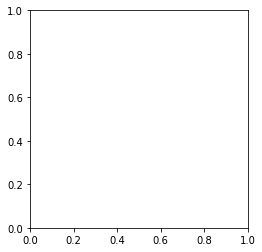

In [148]:
# Read a batch of data and their labels and display them
# Note that since data are transformed, they are between [-1,1]
imgs, labels = (next(iter(train_dataset)))
print(np.shape(imgs.numpy()))
# imgs = np.squeeze(imgs)
plt.imshow(imgs.cpu().numpy(),cmap='gray', vmin=-1, vmax=1) #.transpose()

In [112]:
# num_epochs=2 # Feel free to change it
# for epoch in range(num_epochs):
#     for data in dataloader:
#         [img,label] = data

In [132]:
train_loader = DataLoader( train_dataset,batch_size=64, shuffle=True)
test_loader = DataLoader( test_dataset,batch_size=64, shuffle=True)

In [131]:
class Net(nn.Module):
    # This part defines the layers
    def __init__(self):
        super(Net, self).__init__()
        # At first there is only 1 channel (greyscale). The next channel size will be 10. 
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        # Then, going from channel size (or feature size) 10 to 20. 
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        # Now let us create some feed foreward layers in the end. Remember the sizes (from 320 to 50)
        self.fc1 = nn.Linear(320, 50)
        # The last layer should have an output with the same dimension as the number of classes
        self.fc2 = nn.Linear(50, 10)

    # And this part defines the way they are connected to each other
    # (In reality, it is our foreward pass)
    def forward(self, x):
        

        # F.relu is ReLU activation. F.max_pool2d is a max pooling layer with n=2
        # Max pooling simply selects the maximum value of each square of size n. Effectively dividing the image size by n
        # At first, x is out input, so it is 1x28x28
        # After the first convolution, it is 10x24x24 (24=28-5+1, 10 comes from feature size)
        # After max pooling, it is 10x12x12
        # ReLU doesn't change the size
        x = F.relu(F.max_pool2d(self.conv1(x), 2))

        # Again, after convolution layer, size is 20x8x8 (8=12-5+1, 20 comes from feature size)
        # After max pooling it becomes 20x4x4
        x = F.relu(F.max_pool2d(self.conv2(x), 2))

        # This layer is an imaginary one. It simply states that we should see each member of x
        # as a vector of 320 elements, instead of a tensor of 20x4x4 (Notice that 20*4*4=320)
        x = x.view(-1, 320)

        # Feedforeward layers. Remember that fc1 is a layer that goes from 320 to 50 neurons
        x = F.relu(self.fc1(x))

        # Output layer
        x = self.fc2(x)

        # We should put an appropriate activation for the output layer.
        return F.log_softmax(x)

In [133]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
data1 = torch.from_numpy(data)
d = torch.exp(network(data1))
print(d[1])
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(3)]

tensor([0.0878, 0.1123, 0.1095, 0.0977, 0.1122, 0.0983, 0.0903, 0.1031, 0.0915,
        0.0974], grad_fn=<SelectBackward0>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [121]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target) #negative log liklhood loss
    loss.backward()
    optimizer.step()
    if batch_idx % 20 == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), '/model.pth')
      torch.save(optimizer.state_dict(), '/optimizer.pth')

def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [134]:
for epoch in range(1, 20):
 train(epoch)
 test()

RuntimeError: ignored

In [ ]:
test()

In [ ]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.legend(['Train Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
